In [2]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns

from matplotlib import colors
from copy import deepcopy


%matplotlib inline

In [3]:
from copy import deepcopy

from rashomon import tva
from rashomon import loss
from rashomon import counter
from rashomon import metrics
from rashomon import extract_pools
from rashomon.aggregate import RAggregate_profile, RAggregate, find_profile_lower_bound, find_feasible_combinations, remove_unused_poolings
from rashomon.sets import RashomonSet, RashomonProblemCache, RashomonSubproblemCache

%load_ext autoreload
%autoreload 2

# Read processed data

In [4]:
df = pd.read_csv("../Data/NHANES_telomere.csv")
df_std = pd.read_csv("../Data/NHANES_telomere_std.csv")

df.head()

,Telomean,HoursWorked,Gender,Age,Race,Education,MaritalStatus,HouseholdIncome
0,0.389337,>=41,Female,<=18,Hispanic,< GED,Single,20k-45k
1,0.389337,21-40,Female,31-50,Other,College,Married,20k-45k
2,0.433244,>=41,Male,>=70,White,GED,Married,<20k
3,0.433244,21-40,Male,31-50,White,College,Married,45k-75k
4,0.443293,>=41,Female,31-50,Other,College,Married,>=75k


In [5]:
hours_worked_map = {
    "<=20": 1,
    "21-40": 2,
    ">=41": 3
}

gender_map = {
    "Female": 1,
    "Male": 2
}

age_map = {
    "<=18": 1,
    "19-30": 2,
    "31-50": 3,
    "51-70": 4,
    ">=70": 5
}

race_map = {
    "White": 1,
    "Black": 2,
    "Hispanic": 3,
    "Other": 3
}

education_map = {
    "< GED": 1,
    "GED": 2,
    "College": 3
}

marital_status_map = {
    "Single": 1,
    "Married": 2,
    "Divorced/Widowed": 3
}

income_map = {
    "<20k": 1,
    "20k-45k": 2,
    "45k-75k": 3,
    ">=75k": 4
}


df["HoursWorked"] = df["HoursWorked"].map(hours_worked_map)
df["Gender"] = df["Gender"].map(gender_map)
df["Age"] = df["Age"].map(age_map)
df["Race"] = df["Race"].map(race_map)
df["Education"] = df["Education"].map(education_map)
df["MaritalStatus"] = df["MaritalStatus"].map(marital_status_map)
df["HouseholdIncome"] = df["HouseholdIncome"].map(income_map)



df_std["HoursWorked"] = df_std["HoursWorked"].map(hours_worked_map)
df_std["Gender"] = df_std["Gender"].map(gender_map)
df_std["Age"] = df_std["Age"].map(age_map)
df_std["Race"] = df_std["Race"].map(race_map)
df_std["Education"] = df_std["Education"].map(education_map)
df_std["MaritalStatus"] = df_std["MaritalStatus"].map(marital_status_map)
df_std["HouseholdIncome"] = df_std["HouseholdIncome"].map(income_map)


df2 = df.drop(df[df['Telomean'] > 9].index)
df_std_2 = df_std.drop(df_std[df_std['Telomean'] > 9].index)

df.head()

,Telomean,HoursWorked,Gender,Age,Race,Education,MaritalStatus,HouseholdIncome
0,0.389337,3,1,1,3,1,1,2
1,0.389337,2,1,3,3,3,2,2
2,0.433244,3,2,5,1,2,2,1
3,0.433244,2,2,3,1,3,2,3
4,0.443293,3,1,3,3,3,2,4


In [13]:
# np.random.seed(3)

# category = "Gender"

# fig, ax = plt.subplots(figsize=(5,5))

# ax.spines[['right', 'top', 'left', 'bottom']].set_visible(False)

# # x_ticks = np.sort(pd.unique(beta_df[category])) - 1
# # x_labels = categories_values[category]

# # # Draw vertical grid lines
# # vert_line_y = [np.min(beta_subset) *0.8, np.max(beta_subset) * 1.1]
# # for x_tick in x_ticks:
# #     vert_line_x = [x_tick, x_tick]
# #     ax.plot(vert_line_x, vert_line_y, color="black", linewidth=0.7)

# # # Draw horizontal grid lines
# # hor_line_x = [np.min(x_ticks)-0.3, np.max(x_ticks)+0.3]
# # hor_line_y_vals = [0.8, 1.0, 1.2, 1.4, 1.6]
# # for y_val in hor_line_y_vals:
# #     hor_line_y = [y_val, y_val]
# #     ax.plot(hor_line_x, hor_line_y, color="black", linewidth=0.7, ls="--")

# # The actual plot
# # ax = sns.violinplot(x=category, y="Telostd", data=df_std_2, color="gray", edgecolor="black", linewidth=0.7,
# #                   # size=5,
# #                     alpha=0.8,
# #                     # jitter=0.15,
# #                     dodge=True)#, saturation=1)
# ax = sns.violinplot(x=category, y="Telomean", data=df_std_2, color="gray", edgecolor="black", linewidth=0.7,
#                   # size=5,
#                     alpha=0.8,
#                     # jitter=0.15,
#                     dodge=True)#, saturation=1)


# ax.set_ylabel("Average effects in the Rashomon set")
# ax.set_xlabel(category)
# ax.set_title("")
# # ax.set_xticks(x_ticks, x_labels)
# yticks = [0.006, 0.008, 0.010, 0.012, 0.014, 0.016]
# yticks_labels = ["$" + str(round(x * 100, 2)) for x in yticks]
# # ax.set_yticks(yticks, yticks_labels)


# # plt.savefig("../Figures/price_charity/conditional_effects.png", dpi=300, bbox_inches="tight")
# # plt.savefig("../Figures/price_charity/rset_size_dist_poster.pdf", dpi=600, bbox_inches="tight")
# plt.show()

In [6]:
Z = df.to_numpy()

# Delete the outlier
Z = np.delete(Z, [4877], axis=0)

X = Z[:, [1, 2, 3, 5]]
y = Z[:, 0]
# y = (y - np.min(y)) / (np.max(y) - np.min(y))
y = y.reshape((-1, 1))

num_data = X.shape[0]
print(f"There are {num_data} data points")

There are 4877 data points


# Analysis

In [7]:
M = 4
R = np.array([4, 3, 6, 4])

num_profiles = 2**M
profiles, profile_map = tva.enumerate_profiles(M)

all_policies = tva.enumerate_policies(M, R)
num_policies = len(all_policies)

policies_profiles = {}
policies_profiles_masked = {}
policies_ids_profiles = {}
for k, profile in enumerate(profiles):

    policies_temp = [(i, x) for i, x in enumerate(all_policies) if tva.policy_to_profile(x) == profile]
    unzipped_temp = list(zip(*policies_temp))
    policies_ids_k = list(unzipped_temp[0])
    policies_k = list(unzipped_temp[1])
    policies_profiles[k] = deepcopy(policies_k)
    policies_ids_profiles[k] = policies_ids_k

    profile_mask = list(map(bool, profile))

    # Mask the empty arms
    for idx, pol in enumerate(policies_k):
        policies_k[idx] = tuple([pol[i] for i in range(M) if profile_mask[i]])
    policies_profiles_masked[k] = policies_k

In [8]:
D = np.zeros(shape=y.shape, dtype=np.int64)
profiles_in_data = []
for i in range(num_data):
    policy_i = tuple([int(x) for x in X[i, :]])
    policy_idx = [idx for idx in range(num_policies) if all_policies[idx] == policy_i]
    profiles_in_data.append(tva.policy_to_profile(policy_i))
    D[i, 0] = int(policy_idx[0])


# policy_means = loss.compute_policy_means(D, y, num_policies)



# true_best_eff = np.max(mu_policies)
# print(true_best_eff)
# np.where(mu_policies == true_best_eff)

In [9]:
race_profiles = np.unique(Z[:, 4])

all_active_profile = tuple([1] * M)

policies_temp = [(i, x) for i, x in enumerate(all_policies) if tva.policy_to_profile(x) == all_active_profile]
unzipped_temp = list(zip(*policies_temp))
policy_race_idx = list(unzipped_temp[0])
policy_race = list(unzipped_temp[1])

D_race = {}
X_race = {}
y_race = {}
policy_means_race = {}
mu_policies_race = {}
true_best_eff_race = {}
policy_means = np.zeros(shape=(len(policy_race), 2))
for race in race_profiles:
    idx = np.where(Z[:, 4] == race)
    X_race[race] = X[idx, :][0]
    y_race[race] = y[idx, :][0]
    num_data_race = X_race[race].shape[0]
    
    D_race[race] = np.zeros(shape=y_race[race].shape, dtype=np.int64)
    for i in range(num_data_race):
        policy_i = tuple([int(x) for x in X_race[race][i, :]])
        policy_idx = [idx for idx in range(num_policies) if all_policies[idx] == policy_i]
        D_race[race][i, 0] = int(policy_idx[0])
    
    range_list = list(np.arange(len(policy_race_idx)))
    policy_map = {i: x for i, x in zip(policy_race_idx, range_list)}
    D_race[race] = np.vectorize(policy_map.get)(D_race[race])


    policy_means_race[race] = loss.compute_policy_means(D_race[race], y_race[race], len(policy_race))
    
    nodata_idx = np.where(policy_means_race[race][:, 1] == 0)[0]
    policy_means_race[race][nodata_idx, 0] = -np.inf
    policy_means_race[race][nodata_idx, 1] = 1
    mu_policies_race[race] = policy_means_race[race][:, 0] / policy_means_race[race][:, 1]
    policy_means_race[race][nodata_idx, 1] = 0

    policy_means_race[race][nodata_idx, 0] = 0
    policy_means += policy_means_race[race]
    policy_means_race[race][nodata_idx, 0] = -np.inf

    true_best_eff_race[race] = np.max(mu_policies_race[race])
    # print(true_best_eff, np.where(mu_policies_race[race] == true_best_eff_race[race]))

nodata_idx = np.where(policy_means[:, 1] == 0)[0]
policy_means[nodata_idx, 0] = -np.inf
policy_means[nodata_idx, 1] = 1
mu_policies = policy_means[:, 0] / policy_means[:, 1]
policy_means[nodata_idx, 1] = 0

true_best_eff = np.max(mu_policies)
# print(true_best_eff, np.where(mu_policies == true_best_eff))

In [10]:
D_remapped = D.copy()
range_list = list(np.arange(len(policy_race_idx)))
policy_map = {i: x for i, x in zip(policy_race_idx, range_list)}
D_remapped = np.vectorize(policy_map.get)(D_remapped)

In [11]:
policy_race_idx_full = {}
for k, race in enumerate(race_profiles):
    policy_race_idx_full[k] = (k*len(range_list) + np.array(range_list)).tolist()

In [12]:
policy_means_race_full = np.concatenate((policy_means_race[1], policy_means_race[2], policy_means_race[3]), axis=0)

## Enumerate the Rashomon set

In [13]:
# H = 100
H = np.inf

# # This is too restrictive
# reg = 1e-2

# With reg = 1e-5, theta = 0.09, H = 60
# Best loss = 0.06423696912419681, Worst loss = 0.06535629544158826, epsilon = 0.01742495532794093

reg = 1e-5
# theta = 0.09

best_loss = 0.06423696912419681
# eps = 0.01
eps = 0.004
theta = best_loss * (1 + eps)
print(theta)

0.0644939170006936


In [14]:
# # In the best case, every other profile becomes a single pool
# # So max number of pools per profile is adjusted accordingly
# # H_profile = H - num_profiles + 1
# unordered_factors = race_profiles
# num_unordered_factors = len(unordered_factors)
# H_profile = H - num_unordered_factors + 1

# # Subset data by profiles and find equiv policy lower bound
# D_profiles = {}
# y_profiles = {}
# policies_profiles = {}
# policy_means_profiles = {}
# eq_lb_profiles = np.zeros(shape=(num_unordered_factors,))
# for k, profile in enumerate(unordered_factors):

#     policy_profiles_idx_k = policy_race_idx
#     policies_profiles[k] = policy_race

#     D_k = D_race[profile]
#     # range_list = list(np.arange(len(policy_profiles_idx_k)))
#     # policy_map = {i: x for i, x in zip(policy_profiles_idx_k, range_list)}
#     # D_k = np.vectorize(policy_map.get)(D_k)
#     y_k = y_race[profile]
#     D_profiles[k] = D_k
#     y_profiles[k] = y_k

#     if D_k is None:
#         policy_means_profiles[k] = None
#         eq_lb_profiles[k] = 0
#         H_profile += 1
#     else:
#         policy_means_k = policy_means_race[profile]
#         policy_means_profiles[k] = policy_means_k
#         eq_lb_profiles[k] = find_profile_lower_bound(D_k, y_k, policy_means_k)

# eq_lb_profiles /= num_data
# eq_lb_sum = np.sum(eq_lb_profiles)
# print(eq_lb_profiles, eq_lb_sum)

# # # Now solve each profile independently
# # # This step can be parallelized
# rashomon_profiles: list[RashomonSet] = [None]*num_unordered_factors
# feasible = True
# for k, profile in enumerate(unordered_factors):
#     theta_k = theta - (eq_lb_sum - eq_lb_profiles[k])
#     print(theta_k)
#     D_k = D_profiles[k]
#     y_k = y_profiles[k]

#     policies_k = policies_profiles[k]
#     policy_means_k = policy_means_profiles[k]
#     profile_mask = list(map(bool, all_active_profile))
#     # print(profile_mask)

#     # # Mask the empty arms
#     for idx, pol in enumerate(policies_k):
#         policies_k[idx] = tuple([pol[i] for i in range(M) if profile_mask[i]])
#     # R_k = R[profile_mask]
#     # M_k = np.sum(profile)
#     R_k = R
#     M_k = M
#     # print(len(policies_k), policy_means_k.shape)

#     if D_k is None:
#         # TODO: Put all possible sigma matrices here and set loss to 0
#         rashomon_profiles[k] = RashomonSet(shape=None)
#         rashomon_profiles[k].P_qe = [None]
#         rashomon_profiles[k].Q = np.array([0])
#         continue

#     # Control group is just one policy
#     if M_k == 0:
#         rashomon_k = RashomonSet(shape=None)
#         control_loss = eq_lb_profiles[k] + reg
#         rashomon_k.P_qe = [None]
#         rashomon_k.Q = np.array([control_loss])
#     else:
#         rashomon_k = RAggregate_profile(M_k, R_k, H_profile, D_k, y_k, theta_k, all_active_profile, reg,
#                                         policies_k, policy_means_k, normalize=num_data)
#         rashomon_k.calculate_loss(D_k, y_k, policies_k, policy_means_k, reg, normalize=num_data)

#     rashomon_k.sort()
#     rashomon_profiles[k] = rashomon_k
#     if len(rashomon_k) == 0:
#         feasible = False
#         print(f"No Rashomon set for race profile {profile}")
#         break
#     else:
#         print(f"Race: {profile}. Found {len(rashomon_profiles[k])} partitions")
        

# # Combine solutions in a feasible way
# if feasible:
#     R_set = find_feasible_combinations(rashomon_profiles, theta, H, sorted=True)
# else:
#     R_set = []
# if len(R_set) > 0:
#     rashomon_profiles = remove_unused_poolings(R_set, rashomon_profiles)

# print(len(R_set))

In [ ]:
# for k, profile in enumerate(race_profiles):
#     print(f"Race: {profile}. Found {len(rashomon_profiles[k])} partitions")

In [ ]:
# rashomon_homogeneous = RAggregate_profile(M, R, H, D_remapped, y, theta, all_active_profile, reg,
#                                           policy_race, policy_means, normalize=num_data)
# rashomon_homogeneous.calculate_loss(D_remapped, y, policy_race, policy_means, reg, normalize=num_data)

# print(len(rashomon_homogeneous))

In [ ]:
# R_set_pruned = []

# for r in R_set:
#     current_sigma = None
#     # homoegeneous = False
#     homoegeneous = True
#     for race in race_profiles:
#         race = int(race) - 1
#         sigma_id = r[race]
#         sigma_race = rashomon_profiles[race].sigma[sigma_id]
#         if current_sigma is None:
#             current_sigma = sigma_race
#         elif not np.array_equal(current_sigma, sigma_race):
#             homoegeneous = False
#             break
    
#     if homoegeneous:
#         found_in_homogeneous = False
#         for idx, r_sigma in enumerate(rashomon_homogeneous.sigma):
#             if np.array_equal(r_sigma, current_sigma):
#                 found_in_homogeneous = True
#                 R_set_pruned.append([-1, idx])
#                 break
#         if not found_in_homogeneous:
#             print("Not found :(")
#         else:
#             R_set_pruned.append(r)
#     else:
#         R_set_pruned.append(r)

# print(len(R_set_pruned))

## Pickling
Save and load the pickle file for the Rashomon set with parameters
\begin{align*}
H &= 100 \\
\lambda &= 10^{-4} \\
\epsilon &= 0.01 \text{ or } \epsilon = 0.004\\
\theta &= 0.06487933881543878
\end{align*}

In [ ]:
# import pickle

#full_rashomon_data = {
#   "R_set_pruned": R_set_pruned,
#    "rashomon_profiles": rashomon_profiles,
#    "rashomon_homogeneous": rashomon_homogeneous
#} 

#with open("../Results/nhanes_r_set_outlier_small_eps.pkl", "wb") as f:
#    pickle.dump(full_rashomon_data, f, pickle.HIGHEST_PROTOCOL)
#
#print("Done pickling!")

In [16]:
import pickle


pickle_fname = "../Results/harvard_talk_april_11_pickles/NHANES/nhanes_r_set_outlier_small_eps.pkl"
# pickle_fname = "../Results/nhanes_r_set_outlier_small_eps.pkl"

with open(pickle_fname, "rb") as f:
    full_rashomon_data = pickle.load(f)

R_set_pruned = full_rashomon_data["R_set_pruned"]
rashomon_profiles = full_rashomon_data["rashomon_profiles"]
rashomon_homogeneous = full_rashomon_data["rashomon_homogeneous"]

## Do analysis on the Rashomon set

In [17]:
model_losses = []
model_sizes = []

for i, r in enumerate(R_set_pruned):
    if r[0] == -1:
        model_i = r[1]
        loss_i = rashomon_homogeneous.loss[model_i]
        size_i = rashomon_homogeneous.pools[model_i]
    else:
        model_i = r
        loss_i = 0
        size_i = 0
        for race, race_model in enumerate(model_i):
            loss_i += rashomon_profiles[race].loss[race_model]
            size_i += rashomon_profiles[race].pools[race_model]
    model_losses.append(loss_i)
    model_sizes.append(size_i)

model_losses = np.array(model_losses)
model_sizes = np.array(model_sizes)
# model_mses = model_losses - reg * model_sizes

best_loss = np.min(model_losses)
worst_loss = np.max(model_losses)

eps = (worst_loss - best_loss) / best_loss
print(f"Best loss = {best_loss}, Worst loss = {worst_loss}, epsilon = {eps}")

Best loss = 0.06415039215250254, Worst loss = 0.06449391696460308, epsilon = 0.005354991615388533


In [18]:
model_post_prob = np.exp(-model_losses)

rel_post_prob_ratio = (model_post_prob - np.max(model_post_prob)) / np.max(model_post_prob)


In [34]:
# scaled_prob_threshold = 0.6
# model_size_threshold = 80

# q0 = best_loss
# strict_eps = 0.002
# loss_threshold = q0 * (1 + strict_eps)

# precomputed_pools = {}

# R_set_2 = []
# model_sizes_2 = []
# model_losses_2 = []
# model_pools_2 = []
# model_pool_means_2 = []
# for idx, r_set in enumerate(R_set_pruned):
    
#     if model_losses[idx] > loss_threshold:
#         continue

#     if r_set[0] != -1:
#         pi_policies_profiles_r = {}
#         for race, model_race in enumerate(r_set):
#             sigma_r_prof = rashomon_profiles[race].sigma[model_race]
#             sigma_bytes = sigma_r_prof.tobytes()
#             if sigma_bytes in precomputed_pools.keys():
#                 _, pi_policies_r_k = precomputed_pools[sigma_bytes]
#             else:
#                 pi_pools_r_k, pi_policies_r_k = extract_pools.extract_pools(policy_race, sigma_r_prof)
#                 precomputed_pools[sigma_bytes] = (pi_pools_r_k, pi_policies_r_k)
#             pi_policies_profiles_r[race] = pi_policies_r_k
    
#         pi_pools_r, pi_policies_r = extract_pools.aggregate_pools(pi_policies_profiles_r, policy_race_idx_full)
#         pool_means_r = loss.compute_pool_means(policy_means_race_full, pi_pools_r)

#     else:
#         sigma_r = rashomon_homogeneous.sigma[r_set[1]]
#         sigma_bytes = sigma_r.tobytes()
#         if sigma_bytes in precomputed_pools.keys():
#             pi_pools_r, pi_policies_r = precomputed_pools[sigma_bytes]
#         else:
#             pi_pools_r, pi_policies_r = extract_pools.extract_pools(policy_race, sigma_r)
#             precomputed_pools[sigma_bytes] = (pi_pools_r, pi_policies_r)
#         # pi_pools_r, pi_policies_r = extract_pools.extract_pools(policy_race, sigma_r)
#         pool_means_r = loss.compute_pool_means(policy_means, pi_pools_r)
#         # TODO: Check whether the policy ids are correctly mapped
#         # If not, map them here instead of when estimating effects


#     R_set_2.append(r_set)
#     model_sizes_2.append(model_sizes[idx])
#     model_losses_2.append(model_losses[idx])
#     model_pools_2.append(pi_pools_r)
#     model_pool_means_2.append(pool_means_r)

# print(len(R_set_2))


# model_sizes_2 = np.array(model_sizes_2)
# model_losses_2 = np.array(model_losses_2)
# model_mses_2 = model_losses_2 - reg * model_sizes_2
# model_post_prob_2 = np.exp(-model_losses_2)
# model_scaled_post_prob_2 = model_post_prob_2 - np.min(model_post_prob_2)
# model_scaled_post_prob_2 = model_scaled_post_prob_2 / np.max(model_scaled_post_prob_2)


# best_loss = np.min(model_losses_2)
# worst_loss = np.max(model_losses_2)

# eps = (worst_loss - best_loss) / best_loss
# print(f"Best loss = {best_loss}, Worst loss = {worst_loss}, epsilon = {eps}")

2435
Best loss = 0.06415039215250254, Worst loss = 0.06427866921105135, epsilon = 0.0019996301541519183


In [36]:
# rashomon_reduced_data = {
#     "R_set": R_set_2,
#     "sizes": model_sizes_2,
#     "losses": model_losses_2,
#     "pools": model_pools_2,
#     "pool_means": model_pool_means_2
# }

# with open("../Results/nhanes_pruned_results_outlier.pkl", "wb") as f:
#     pickle.dump(rashomon_reduced_data, f, pickle.HIGHEST_PROTOCOL)

In [20]:
pruned_pickle_fname = "../Results/harvard_talk_april_11_pickles/NHANES/nhanes_pruned_results_outlier.pkl"
# pruned_pickle_fname = "../Results/nhanes_pruned_results_outlier.pkl"

with open(pruned_pickle_fname, "rb") as f:
    rashomon_reduced_data = pickle.load(f)

R_set_2 = rashomon_reduced_data["R_set"]
model_sizes_2 = rashomon_reduced_data["sizes"]
model_losses_2 = rashomon_reduced_data["losses"]
model_pools_2 = rashomon_reduced_data["pools"]
model_pool_means_2 = rashomon_reduced_data["pool_means"]


# model_mses_2 = model_losses_2 - reg * model_sizes_2
model_post_prob_2 = np.exp(-model_losses_2)
model_scaled_post_prob_2 = model_post_prob_2 - np.min(model_post_prob_2)
model_scaled_post_prob_2 = model_scaled_post_prob_2 / np.max(model_scaled_post_prob_2)


best_loss = np.min(model_losses_2)
worst_loss = np.max(model_losses_2)

eps = (worst_loss - best_loss) / best_loss
print(f"Best loss = {best_loss}, Worst loss = {worst_loss}, epsilon = {eps}")

Best loss = 0.06415039215250254, Worst loss = 0.06427866921105135, epsilon = 0.0019996301541519183


In [21]:
rel_post_prob_ratio_2 = (model_post_prob_2 - np.max(model_post_prob)) / np.max(model_post_prob)
min_rel_post_prob_2 = np.min(rel_post_prob_ratio_2)

print(min_rel_post_prob_2)

-0.00012826883139867648


# Plots

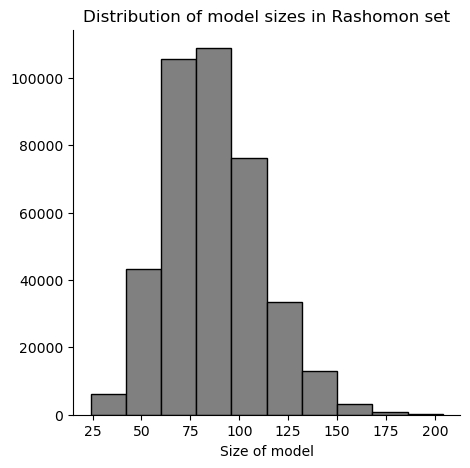

In [22]:
fig, ax = plt.subplots(figsize=(5,5))

ax.spines[['right', 'top']].set_visible(False)

ax.hist(model_sizes,
        color="grey", edgecolor="black")

# ax.set_xlim(1, H)
ax.set_xlabel("Size of model")
ax.set_ylabel("")
ax.set_title("Distribution of model sizes in Rashomon set")

# ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))

# plt.savefig("../Figures/nhanes/rset_size_dist.png", dpi=300, bbox_inches="tight")
# plt.savefig("../Figures/nhanes/rset_size_dist_poster.pdf", dpi=600, bbox_inches="tight")
plt.show()

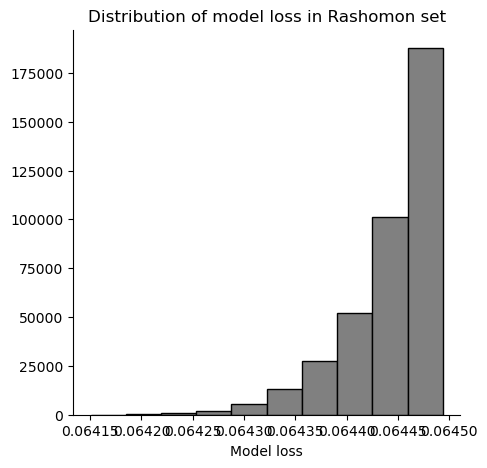

In [23]:
fig, ax = plt.subplots(figsize=(5,5))

ax.spines[['right', 'top']].set_visible(False)

ax.hist(model_losses,
        color="grey", edgecolor="black")

# ax.set_xlim(1, H)
ax.set_xlabel("Model loss")
ax.set_ylabel("")
ax.set_title("Distribution of model loss in Rashomon set")

# ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))

# plt.savefig("../Figures/nhanes/rset_loss_dist.png", dpi=300, bbox_inches="tight")
# plt.savefig("../Figures/nhanes/rset_loss_dist_poster.pdf", dpi=600, bbox_inches="tight")
plt.show()

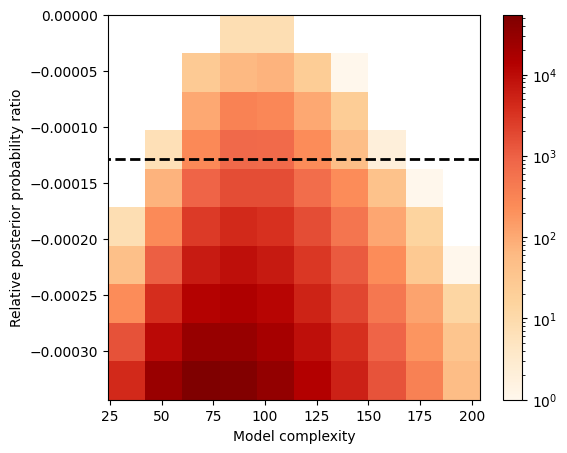

In [46]:
fig, ax = plt.subplots(figsize=(6,5))

h = ax.hist2d(model_sizes, rel_post_prob_ratio, norm=colors.LogNorm(),
             cmap="OrRd")

ax.plot([-1, 210], [min_rel_post_prob_2, min_rel_post_prob_2],
        color="black", linestyle="--", linewidth=2)
# ax.plot([80, 80], [min_rel_post_prob_2, 0.1],
#         color="black", linestyle="--", linewidth=2)

cb = fig.colorbar(h[3], norm=colors.NoNorm, ax=ax)

ax.set_xlabel("Model complexity")
ax.set_ylabel("Relative posterior probability ratio")


# plt.savefig("../Figures/nhanes/rset_2d_hist_cutoff.png", dpi=300, bbox_inches="tight")
# plt.savefig("../Figures/nhanes/rset_2d_hist.png", dpi=300, bbox_inches="tight")
# plt.savefig("../Figures/nhanes/rset_2d_hist_poster.pdf", dpi=600, bbox_inches="tight")
plt.show()

## Top left of the 2D histogram

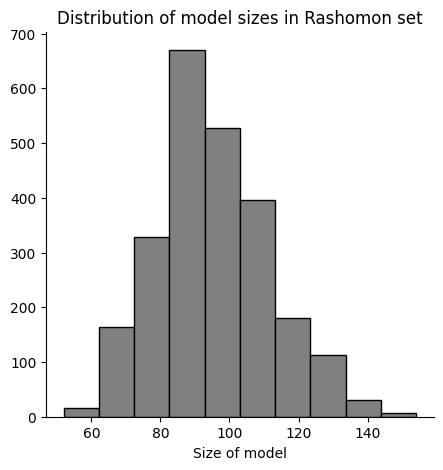

In [47]:
fig, ax = plt.subplots(figsize=(5,5))

ax.spines[['right', 'top']].set_visible(False)

ax.hist(model_sizes_2,
        color="grey", edgecolor="black")

# ax.set_xlim(1, H)
ax.set_xlabel("Size of model")
ax.set_ylabel("")
ax.set_title("Distribution of model sizes in Rashomon set")

# ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))

# plt.savefig("../Figures/nhanes/rset_size_dist_refined.png", dpi=300, bbox_inches="tight")
# plt.savefig("../Figures/nhanes/rset_size_dist_poster.pdf", dpi=600, bbox_inches="tight")
plt.show()

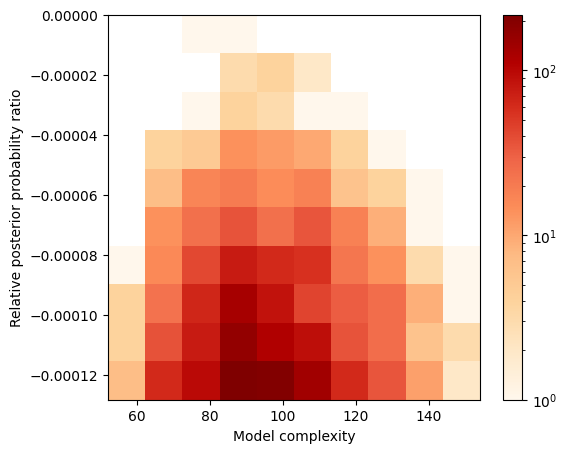

In [48]:
fig, ax = plt.subplots(figsize=(6,5))

# h = ax.hist2d(model_sizes, model_post_prob, norm=colors.LogNorm(),
#              cmap="OrRd")
h = ax.hist2d(model_sizes_2, rel_post_prob_ratio_2, norm=colors.LogNorm(),
             cmap="OrRd")
fig.colorbar(h[3], norm=colors.NoNorm, ax=ax)

ax.set_xlabel("Model complexity")
ax.set_ylabel("Relative posterior probability ratio")


# plt.savefig("../Figures/nhanes/rset_2d_hist_refined.png", dpi=300, bbox_inches="tight")
# plt.savefig("../Figures/nhanes/rset_2d_hist_poster.pdf", dpi=600, bbox_inches="tight")
plt.show()

## Plot epsilon vs number of models and error

In [8]:
sorted_losses = np.sort(model_losses)
sorted_epsilon = sorted_losses / np.min(model_losses) - 1


num_models = np.arange(0, len(model_losses))+1
model_errors = sorted_losses * num_models
num_models_2 = len(R_set_2)

est_err = 1 / (num_models * np.exp(-sorted_losses))
# est_err_shifted = est_err - np.min(est_err)


our_threshold = np.max(model_losses_2) / np.min(model_losses) - 1

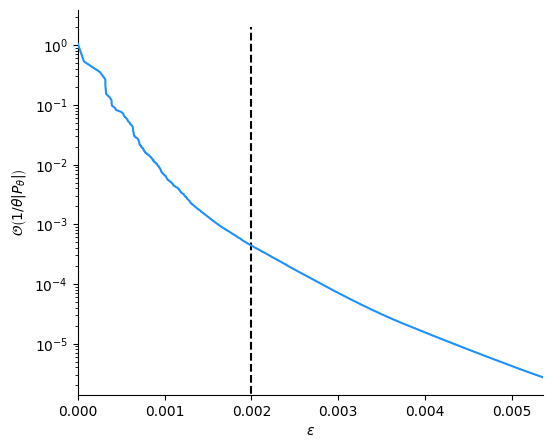

In [9]:


fig, ax = plt.subplots(figsize=(6,5))

ax.spines[['right', 'top']].set_visible(False)

ax.plot([our_threshold, our_threshold], [0, 2], color="black", ls="--")

ax.plot(sorted_epsilon, est_err,
        color="dodgerblue",
       zorder=3.1)

ax.set_xlabel(r"$\epsilon$")
ax.set_ylabel(r"$\mathcal{O} \left( 1 / \theta |P_{\theta}| \right)$", rotation=90)

# ax.set_yticks([1, 100, 200, 300, 400, 500])

ax.set_xlim(0, np.max(sorted_epsilon))
# ax.set_ylim(0, np.max(est_err))
ax.set_yscale("log")


# plt.savefig("../Figures/nhanes/eps_vs_est_error.png", dpi=300, bbox_inches="tight")

plt.show()

In [27]:
sorted_posteriors = np.exp(-sorted_losses)
map_to_model_ratio = sorted_posteriors / np.max(sorted_posteriors)

n_range = np.arange(len(sorted_posteriors))

In [42]:
len(R_set_2)

2435

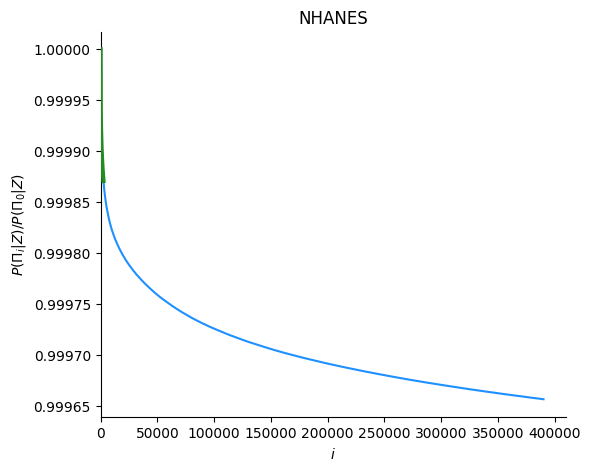

In [84]:
max_idx = 2500

fig, ax = plt.subplots(figsize=(6,5))

ax.spines[['right', 'top']].set_visible(False)

# ax.plot([our_threshold, our_threshold], [0, 2], color="black", ls="--")

ax.plot(n_range, map_to_model_ratio,
        color="dodgerblue",
       zorder=3.1)
ax.plot(n_range[:max_idx], map_to_model_ratio[:max_idx],
        linewidth=3,
        color="forestgreen",
       zorder=3.1)

ax.set_xlabel(r"$i$")
ax.set_ylabel(r"$P(\Pi_i | Z) / P(\Pi_0 | Z)$", rotation=90)

# ax.set_yticks([1, 100, 200, 300, 400, 500])

ax.set_xlim(0) #, np.max(n_range))
# ax.set_ylim(0, np.max(map_to_model_ratio))
# ax.set_xlim(0, np.max(n_range))
# ax.set_ylim(0)
# ax.set_yscale("log")
# ax.set_xscale("log")

ax.set_title("NHANES")


# plt.savefig("../Figures/nhanes/eps_vs_est_error.png", dpi=300, bbox_inches="tight")

plt.show()

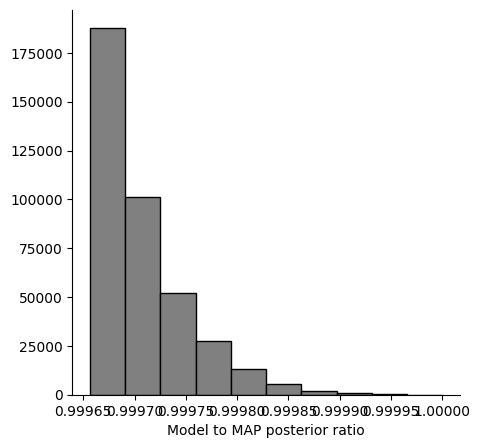

In [87]:
fig, ax = plt.subplots(figsize=(5,5))

ax.spines[['right', 'top']].set_visible(False)

ax.hist(map_to_model_ratio,
        color="grey", edgecolor="black")

# ax.set_xlim(1, H)
ax.set_xlabel("Model to MAP posterior ratio")
ax.set_ylabel("")
ax.set_title("")

# ax.set_xticks(rotate=45)

plt.show()

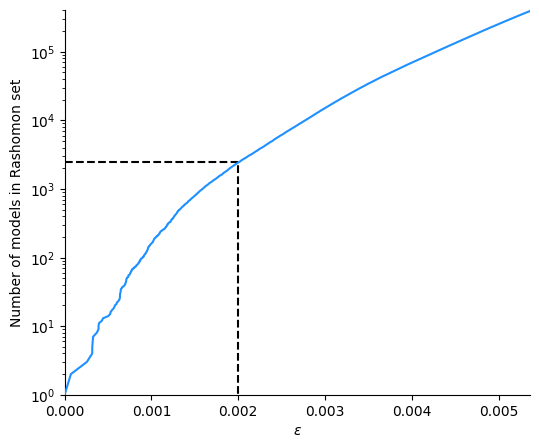

In [53]:
fig, ax = plt.subplots(figsize=(6,5))

ax.spines[['right', 'top']].set_visible(False)


# ax.plot([0, np.max(sorted_epsilon)], [512, 512], color="grey", ls="--")
ax.plot([our_threshold, our_threshold], [0, num_models_2], color="black", ls="--")
# ax.plot([0, our_threshold], [101188, 101188], color="black", ls="--")
ax.plot([0, our_threshold], [num_models_2, num_models_2], color="black", ls="--")

ax.plot(sorted_epsilon, num_models,
        color="dodgerblue",
        zorder=3.1)

ax.set_xlabel(r"$\epsilon$")
ax.set_ylabel("Number of models in Rashomon set")

# ax.set_yticks([1, 100, 200, 300, 400, 500])

ax.set_xlim(0, np.max(sorted_epsilon))
ax.set_ylim(1)
ax.set_yscale("log")

# plt.savefig("../Figures/nhanes/eps_vs_size.png", dpi=300, bbox_inches="tight")

plt.show()

### Estimating effects

In [24]:
all_policies_race = []
for race in race_profiles:
    for pol in policy_race:
        pol = tuple([x for x in pol] + [int(race)])
        all_policies_race.append(pol)

In [25]:
policies_present = np.sort(np.unique(D_remapped))

beta = np.zeros(270)


for i, model in enumerate(R_set_2):

    beta_i = np.zeros(270)
    pool_means_i = model_pool_means_2[i]

    # Do some calculation
    for pool_id in range(len(pool_means_i)):
        for policy in model_pools_2[i][pool_id]:
            if model[0] == -1:
                beta_i[policy] = pool_means_i[pool_id]
                beta_i[policy+90] = pool_means_i[pool_id]
                beta_i[policy+180] = pool_means_i[pool_id]
                pass
            else:
                beta_i[policy] = pool_means_i[pool_id]

    beta += beta_i * model_post_prob_2[i]

beta /= np.sum(model_post_prob_2)

beta_subset = beta

beta_subset_sorted = list(np.sort(beta_subset))

policy_id_1 = np.where(beta == beta_subset_sorted[-1])[0][0]
policy_id_2 = np.where(beta == beta_subset_sorted[-2])[0][0]
policy_id_3 = np.where(beta == beta_subset_sorted[-3])[0][0]
policy_id_4 = np.where(beta == beta_subset_sorted[-4])[0][0]
policy_id_worst = np.where(beta == beta_subset_sorted[0])[0][0]

print(f"Best \t\t {all_policies_race[policy_id_1]} \t{beta_subset_sorted[-1]}")
print(f"Second Best \t {all_policies_race[policy_id_2]} \t{beta_subset_sorted[-2]}")
print(f"Third Best \t {all_policies_race[policy_id_3]} \t{beta_subset_sorted[-3]}")
print(f"Fourth Best \t {all_policies_race[policy_id_4]} \t{beta_subset_sorted[-4]}")
print(f"Worst \t\t {all_policies_race[policy_id_worst]} \t{beta_subset_sorted[0]}")

Best 		 (2, 2, 5, 3, 3) 	1.8833240438414425
Second Best 	 (1, 2, 5, 3, 3) 	1.613076593630478
Third Best 	 (2, 2, 5, 2, 3) 	1.4809929721410744
Fourth Best 	 (2, 1, 5, 3, 3) 	1.4452280425672202
Worst 		 (1, 1, 5, 1, 1) 	0.4480949014810601


## Plots for effects

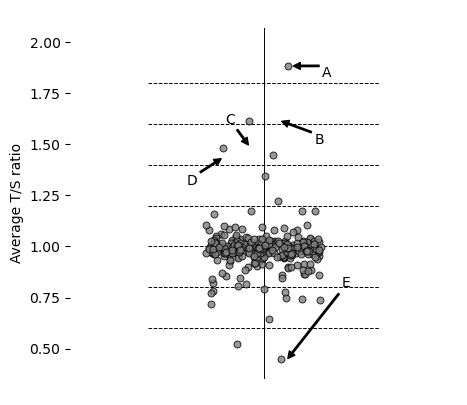

In [26]:
vert_line_x = [0, 0]
vert_line_y = [np.min(beta_subset) *0.9, np.max(beta_subset) * 1.1]

hor_line_x = [-0.5, 0.2]
hor_line_y1 = [0.016, 0.016]
hor_line_y2 = [0.006, 0.006]
hor_line_y3 = [0.012, 0.012]
hor_line_y4 = [0.014, 0.014]
hor_line_y5 = [0.008, 0.008]
hor_line_y6 = [0.010, 0.010]

np.random.seed(3)

fig, ax = plt.subplots(figsize=(5,5))

ax.spines[['right', 'top', 'left', 'bottom']].set_visible(False)

# Draw vertical grid lines
x_ticks = [0]
vert_line_y = [np.min(beta_subset) *0.8, np.max(beta_subset) * 1.1]
for x_tick in x_ticks:
    vert_line_x = [x_tick, x_tick]
    ax.plot(vert_line_x, vert_line_y, color="black", linewidth=0.7)

# Draw horizontal grid lines
hor_line_x = [np.min(x_ticks)-0.3, np.max(x_ticks)+0.3]
hor_line_y_vals = [0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8]
for y_val in hor_line_y_vals:
    hor_line_y = [y_val, y_val]
    ax.plot(hor_line_x, hor_line_y, color="black", linewidth=0.7, ls="--")

ax = sns.stripplot(beta_subset, color="gray", edgecolor="black", linewidth=0.7,
                  size=5, alpha=0.8, jitter=0.15, dodge=True)#, saturation=1)

ax.annotate("A", xy=(0.075, beta_subset_sorted[-1]), xytext=(0.15, 1.83),
            arrowprops=dict(facecolor='black', width=1, headwidth=5, headlength=5, shrink=0.01))
ax.annotate("B", xy=(0.045, beta_subset_sorted[-2]), xytext=(0.13, 1.5),
            arrowprops=dict(facecolor='black', width=1, headwidth=5, headlength=5, shrink=0.01))
ax.annotate("C", xy=(-0.04, beta_subset_sorted[-3]+0.015), xytext=(-0.1, 1.6),
            arrowprops=dict(facecolor='black', width=1, headwidth=5, headlength=5, shrink=0.01))
ax.annotate("D", xy=(-0.11, beta_subset_sorted[-4]-0.015), xytext=(-0.2, 1.3),
            arrowprops=dict(facecolor='black', width=1, headwidth=5, headlength=5, shrink=0.01))
ax.annotate("E", xy=(0.06, beta_subset_sorted[0]), xytext=(0.2, 0.8),
            arrowprops=dict(facecolor='black', width=1, headwidth=5, headlength=5, shrink=0.01),
            label="yadadada")


ax.set_ylabel("Average T/S ratio")
ax.set_xlabel("")
ax.set_title("")
# ax.set_xticks([0], [r"$\beta$"])
ax.set_xticks([], [])
yticks = [0.006, 0.008, 0.010, 0.012, 0.014, 0.016]
yticks_labels = ["$" + str(round(x * 100, 2)) for x in yticks]
# ax.set_yticks(yticks, yticks_labels)

# textstr = """
# A: $2:$1, $25k, 1.5x, Blue
# B: $3:$1, $25k, 1x, Blue
# C: $2:$1, $25k, 1x, Blue
# D: $3:$1, $25k, 1x, Blue
# E: $1:$1, $50k, 1x, Red
# """
# props = dict(facecolor='white', alpha=0.5,
#             edgecolor='white')

# ax.text(0.5, 0.014, textstr, fontsize=10, verticalalignment='top', bbox=props)

# ax.legend([annot5.arrow_patch], (annot5["label"]))


# plt.savefig("../Figures/nhanes/conditional_effects.png", dpi=300, bbox_inches="tight")
# plt.savefig("../Figures/nhanes/conditional_effects.pdf", dpi=600, bbox_inches="tight")
plt.show()

In [66]:
beta_df = []
for idx, policy in enumerate(all_policies_race):
    beta_df.append([beta_subset[idx]] + list(policy))

beta_df = pd.DataFrame(beta_df, columns=["Tel", "Work", "Gender", "Age", "Education", "Race"])

categories_values = {
    "Work": [r"$\leq 20$ hrs", r"$21 - 40$ hrs", r"$\geq 40$ hrs"],
    "Gender": ["Female", "Male"],
    "Age": [r"$\leq 18$", r"$19 - 30$", r"$31 - 50$", r"$51 - 70$", r"$\geq 71$"],
    "Education": ["< GED", "GED", "College"],
    "Race": ["White", "Black", "Other"]
}

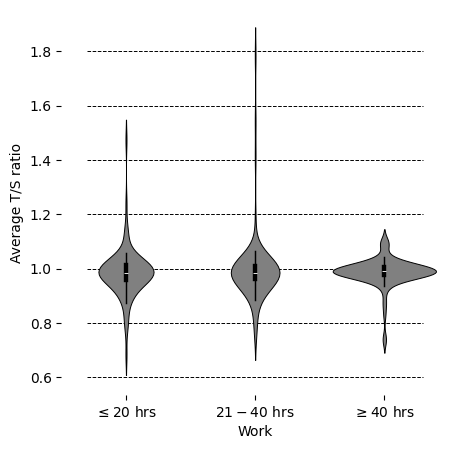

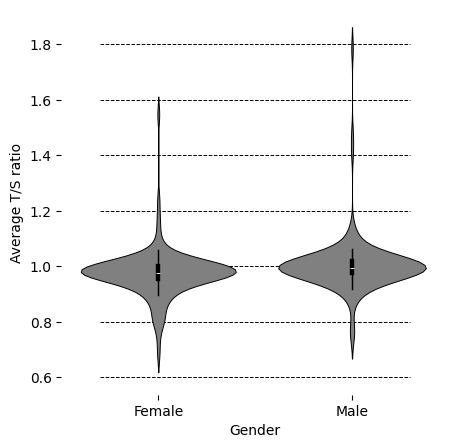

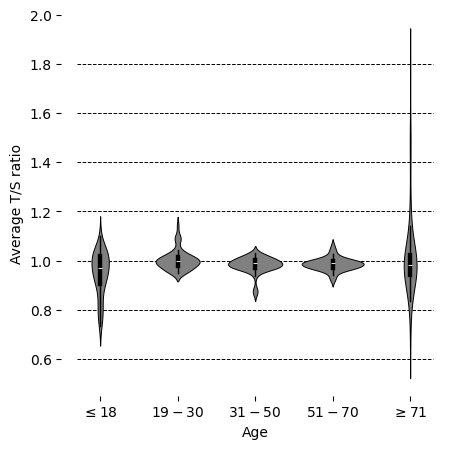

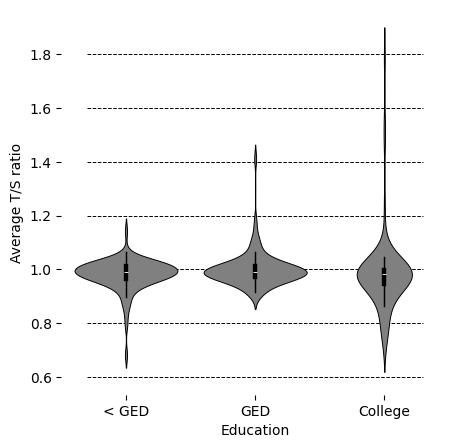

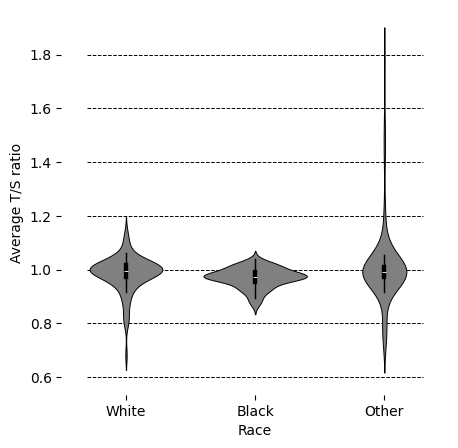

In [67]:
for category in categories_values.keys():

    np.random.seed(3)
    
    # category = "Education"
    
    fig, ax = plt.subplots(figsize=(5,5))
    
    ax.spines[['right', 'top', 'left', 'bottom']].set_visible(False)
    
    x_ticks = np.sort(pd.unique(beta_df[category])) - 1
    x_labels = categories_values[category]
    
    # Draw vertical grid lines
    # vert_line_y = [np.min(beta_subset) *0.8, np.max(beta_subset) * 1.1]
    # for x_tick in x_ticks:
    #     vert_line_x = [x_tick, x_tick]
    #     ax.plot(vert_line_x, vert_line_y, color="black", linewidth=0.7, zorder=1)
    
    # Draw horizontal grid lines
    hor_line_x = [np.min(x_ticks)-0.3, np.max(x_ticks)+0.3]
    hor_line_y_vals = [0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8]
    for y_val in hor_line_y_vals:
        hor_line_y = [y_val, y_val]
        ax.plot(hor_line_x, hor_line_y, color="black", linewidth=0.7, ls="--", zorder=1)
    
    # The actual plot
    ax = sns.violinplot(x=category, y="Tel", data=beta_df, color="gray", edgecolor="black", linewidth=0.7,
                      # size=5,
                        # alpha=0.8,
                        # jitter=0.15,
                        dodge=True,)#, saturation=1)
    
    # ax.annotate("A", xy=(0.075, beta_subset_sorted[-1]), xytext=(0.15, 1.63),
    #             arrowprops=dict(facecolor='black', width=1, headwidth=5, headlength=5, shrink=0.01))
    # ax.annotate("Policy B", xy=(-0.04, beta_subset_sorted[-2]), xytext=(-0.4, 0.015),
    #             arrowprops=dict(facecolor='black', width=1, headwidth=5, headlength=5, shrink=0.01))
    # ax.annotate("Policy C", xy=(0.015, beta_subset_sorted[-3]), xytext=(0.1, 0.015),
    #             arrowprops=dict(facecolor='black', width=1, headwidth=5, headlength=5, shrink=0.01))
    # ax.annotate("Policy D", xy=(0.015, beta_subset_sorted[-4]), xytext=(0.1, 0.013),
    #             arrowprops=dict(facecolor='black', width=1, headwidth=5, headlength=5, shrink=0.01))
    # ax.annotate("Policy E", xy=(-0.015, beta_subset_sorted[0]), xytext=(-0.2, 0.005),
    #             arrowprops=dict(facecolor='black', width=1, headwidth=5, headlength=5, shrink=0.01),
    #             label="yadadada")
    
    
    ax.set_ylabel("Average T/S ratio")
    ax.set_xlabel(category)
    ax.set_title("")
    ax.set_xticks(x_ticks, x_labels)
    yticks = hor_line_y_vals
    yticks_labels = [str(round(x, 2)) for x in yticks]
    # ax.set_yticks(yticks, yticks_labels)
    
    
    
    # plt.savefig(f"../Figures/nhanes/conditional_effects_{category}.png", dpi=300, bbox_inches="tight")
    plt.show()

In [27]:
beta_df2 = beta_df.copy()
beta_df2["Race"] = beta_df2["Race"].map({
    1: "White",
    2: "Black",
    3: "Other"
})


beta_df2["Work"] = beta_df2["Work"].map({
    1: 1,
    2: 1,
    3: 2
})

beta_df2["Education"] = beta_df2["Education"].map({
    1: 1,
    2: 2,
    3: 2
})

beta_df2["Age18"] = beta_df2["Age"].map({
    1: 1,
    2: 2,
    3: 2,
    4: 2,
    5: 2
})
beta_df2["Age50"] = beta_df2["Age"].map({
    1: 1,
    2: 1,
    3: 1,
    4: 2,
    5: 2
})
beta_df2["Age70"] = beta_df2["Age"].map({
    1: 1,
    2: 1,
    3: 1,
    4: 1,
    5: 2
})

categories_values2 = deepcopy(categories_values)
categories_values2["Work"] = [r"$\leq 40$ hrs", "> 40 hrs"]
categories_values2["Education"] = ["< GED", r"$\geq$ GED"]
categories_values2["Age18"] = [r"$\leq 18$", r"$> 18$"]
categories_values2["Age50"] = [r"$\leq 50$", r"$> 50$"]
categories_values2["Age70"] = [r"$\leq 70$", r"$> 70$"]

for category in categories_values2.keys():

    if category == "Race":
        continue

    np.random.seed(3)
    
    # category = "Work"
    
    
    
    x_ticks = np.sort(pd.unique(beta_df2[category])) - 1
    x_labels = categories_values2[category]

    if len(x_ticks) == 2:
        fig_width = 7
    else:
        fig_width = 10
        
    fig, ax = plt.subplots(figsize=(fig_width,5))
    ax.spines[['right', 'top', 'left', 'bottom']].set_visible(False)

    # print(category, x_ticks, x_labels)
    
    # # Draw vertical grid lines
    # vert_line_y = [np.min(beta_subset) *0.8, np.max(beta_subset) * 1.1]
    # for x_tick in x_ticks:
    #     vert_line_x = [x_tick, x_tick]
    #     ax.plot(vert_line_x, vert_line_y, color="black", linewidth=0.7, zorder=1)
    
    # Draw horizontal grid lines
    hor_line_x = [np.min(x_ticks)-0.3, np.max(x_ticks)+0.3]
    hor_line_y_vals = [0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0]
    for y_val in hor_line_y_vals:
        hor_line_y = [y_val, y_val]
        ax.plot(hor_line_x, hor_line_y, color="black", linewidth=0.7, ls="--", zorder=1)
    
    # The actual plot
    g = sns.violinplot(x=category, y="Tel", data=beta_df2, hue="Race",
                       # color="gray",
                        # palette=sns.color_palette("flare", as_cmap=True, n_colors=3),
                       palette=["#c9cba3", "#e26d5c", "#723d46"],
                       # palette=sns.color_palette("cmo.balance", n_colors=64, desat=0.2),
                       edgecolor="black", linewidth=0.7,
                       # size=5,
                        alpha=0.9,
                        dodge=True,
                       inner="quart",
                       # width=1.5,
                       # gap=0.01
                      )#, saturation=1)
    
    
    ax.set_ylabel("Average T/S ratio")
    ax.set_xlabel(category)
    ax.set_title("")
    ax.set_xticks(x_ticks, x_labels)
    yticks = hor_line_y_vals
    yticks_labels = [str(round(x, 2)) for x in yticks]
    # ax.set_yticks(yticks, yticks_labels)
    
    ax.legend(loc="center right", bbox_to_anchor=(1.2,0.5), title="Race")
    
    
    # plt.savefig(f"../Figures/nhanes/conditional_effects_{category}_race.png", dpi=300, bbox_inches="tight")
    plt.show()

NameError: name 'beta_df' is not defined

## Inspecting models

The arms are:
- HoursWorked - 3 levels
- Gender - female, male
- Age - 5 levels
- Education - 3 levels

Race was 3 levels - white, black, other

In [28]:
splits_white = np.zeros(rashomon_profiles[0].sigma[0].shape)
splits_black = np.zeros(splits_white.shape)
splits_other = np.zeros(splits_white.shape)
splits_overall = np.zeros(splits_white.shape)
overall_ctr = 0

for r_set in R_set_2:
    if r_set[0] == -1:
        idx = r_set[1]
        splits_overall += np.abs(rashomon_homogeneous.sigma[idx] - 1)
        splits_white += np.abs(rashomon_homogeneous.sigma[idx] - 1)
        splits_black += np.abs(rashomon_homogeneous.sigma[idx] - 1)
        splits_other += np.abs(rashomon_homogeneous.sigma[idx] - 1)
        overall_ctr += 1
    else:
        idx_white = r_set[0]
        idx_black = r_set[1]
        idx_other = r_set[2]
    
        splits_white += np.abs(rashomon_profiles[0].sigma[idx_white] - 1)
        splits_black += np.abs(rashomon_profiles[1].sigma[idx_black] - 1)
        splits_other += np.abs(rashomon_profiles[2].sigma[idx_other] - 1)

splits_white = splits_white / len(R_set_2) # * 100
splits_black = splits_black / len(R_set_2) # * 100
splits_other = splits_other / len(R_set_2) # * 100
if overall_ctr > 0:
    splits_overall = splits_overall / overall_ctr # * 100

In [29]:
print("White\n", splits_white)
print("Black\n", splits_black)
print("Other\n", splits_other)
print("Overall\n", splits_overall)

White
 [[0.88295688 0.95811088        inf        inf]
 [1.                inf        inf        inf]
 [0.99342916 0.99219713 1.         0.49897331]
 [1.         0.06776181        inf        inf]]
Black
 [[0.25831622 0.65585216        inf        inf]
 [1.                inf        inf        inf]
 [0.38685832 0.46078029 0.52895277 0.28459959]
 [0.4788501  0.39958932        inf        inf]]
Other
 [[0.14661191 1.                inf        inf]
 [0.23244353        inf        inf        inf]
 [0.99014374 1.         0.36468172 1.        ]
 [0.94661191 0.23901437        inf        inf]]
Overall
 [[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


In [30]:
best_model_idx = np.argmin(model_losses_2)
worst_model_idx = np.argmax(model_losses_2)

In [31]:
idx = worst_model_idx

num_pools = 0
for k, prof in enumerate(R_set_2[idx]):
    print(rashomon_profiles[k].sigma[prof])
    num_pools += rashomon_profiles[k].pools[prof]
print(f"There are {num_pools} pools.")
best_pool_idx = np.argmax(model_pool_means_2[idx])
print(model_pool_means_2[idx][best_pool_idx])
print([all_policies_race[x] for x in model_pools_2[idx][best_pool_idx]])


worst_pool_idx = np.argmin(model_pool_means_2[idx])
print(model_pool_means_2[idx][worst_pool_idx])
print([all_policies_race[x] for x in model_pools_2[idx][worst_pool_idx]])

[[ 0.  1. inf inf]
 [ 0. inf inf inf]
 [ 0.  0.  0.  1.]
 [ 0.  1. inf inf]]
[[ 1.  0. inf inf]
 [ 0. inf inf inf]
 [ 1.  0.  1.  1.]
 [ 0.  0. inf inf]]
[[ 1.  0. inf inf]
 [ 1. inf inf inf]
 [ 0.  0.  1.  0.]
 [ 0.  1. inf inf]]
There are 72.0 pools.
1.88565430722
[(1, 1, 5, 2, 3), (1, 1, 5, 3, 3), (1, 2, 5, 2, 3), (1, 2, 5, 3, 3), (2, 1, 5, 2, 3), (2, 1, 5, 3, 3), (2, 2, 5, 2, 3), (2, 2, 5, 3, 3)]
0.723769251951
[(1, 2, 3, 1, 1)]


### Heatmap-esque plots

In [32]:
med_tel = np.median(y)
print(med_tel)

0.965991099465


In [33]:
all_policies_race_reverse = {}
for x, y in enumerate(all_policies_race):
    all_policies_race_reverse[y] = x

In [34]:
beta_models = []

for i, model in enumerate(R_set_2):

    beta_i = np.zeros(270)
    pool_means_i = model_pool_means_2[i]

    # Get the beta vector
    for pool_id in range(len(pool_means_i)):
        for policy in model_pools_2[i][pool_id]:
            beta_i[policy] = pool_means_i[pool_id]

    beta_models.append(beta_i)

In [35]:
all_covariate_counts = []
all_model_prob_counts = []

# normalized_model_post_prob_2 = model_post_prob_2 / np.sum(model_post_prob_2)

for covariate_idx in range(4):

    num_cov_values = R[covariate_idx]
    
    counts_per_race = [[] for i in range(num_cov_values - 2)]
    model_prob_per_race = [[] for i in range(num_cov_values - 2)]
    
    # covariate_counts = [{1: [], 2: [], 3: []}] * 2
    covariate_counts = [deepcopy(counts_per_race) for i in range(3)]
    model_probs_counts = [deepcopy(model_prob_per_race) for i in range(3)]
    
    for i, beta_i in enumerate(beta_models): # For each model in the rashomon set
        #2435 models so 2435 betas
        for policy_id, policy in enumerate(all_policies_race): # For each policy
            
            if policy[covariate_idx] == 1:
                continue
                
            control = list(deepcopy(policy))
            control[covariate_idx] = 1
            control_id = all_policies_race_reverse[tuple(control)]
    
            eff = beta_i[policy_id] - beta_i[control_id] # This is the
    
            race = policy[4]
            covariate_val = policy[covariate_idx]
            
            covariate_counts[race - 1][covariate_val - 2].append(eff)
            model_probs_counts[race - 1][covariate_val - 2].append(model_post_prob_2[i])

    all_covariate_counts.append(covariate_counts)
    all_model_prob_counts.append(model_probs_counts)

In [94]:
len(all_policies_race)

270

In [36]:
stds = np.zeros((4, 3))
for covariate_idx in range(4):
    for race_idx in range(3):
        stds[covariate_idx, race_idx] = np.std(all_covariate_counts[covariate_idx][race_idx])

In [37]:
signed_matrices = []
num_bins = 5

def assign_label(a, bins):
    if a == 0:
        return (len(bins) - 1) // 2
    else:
        return np.digitize(a, bins) - (a > 0)
    
assign_label_vec = np.vectorize(assign_label)

for covariate_idx in range(len(all_covariate_counts)):
    signed_counts = []
    for race_idx in range(len(all_covariate_counts[covariate_idx])):
        covariate_counts = all_covariate_counts[covariate_idx]
        # print(f"Covariate: {covariate_idx}, Race: {race_idx}")
        stddev = stds[covariate_idx, race_idx]
        all_eff = np.array(covariate_counts[race_idx]).flatten()
        if num_bins != 3:
            bins = [min(np.min(all_eff), stddev * -(3)) - 1] + [2 * stddev * i for i in np.arange(-1, 2, 3/(num_bins - 2))] + [max(np.max(all_eff), stddev * 3) + 1]
        else:
            bins = [min(np.min(all_eff), stddev * -(3)) - 1] + [0] + [max(np.max(all_eff), stddev * 3) + 1]
        bins = bins[::-1]
        signed_counts_race = []
        # print(len(covariate_counts[race_idx]))
        for idx, cov_counts_r in enumerate(covariate_counts[race_idx]):
            vec = np.array(cov_counts_r)
            counts_vec = np.array([assign_label(vec[i], bins) for i in range(len(vec))])
            counts_vec = np.array([np.dot(np.where(counts_vec == i, 1, 0), all_model_prob_counts[covariate_idx][race_idx][idx]) for i in range(len(bins))])
            counts_vec /= np.sum(counts_vec)
            signed_counts_race.append(counts_vec.copy())
        signed_counts.append(signed_counts_race)
    signed_matrices.append(np.array(signed_counts))

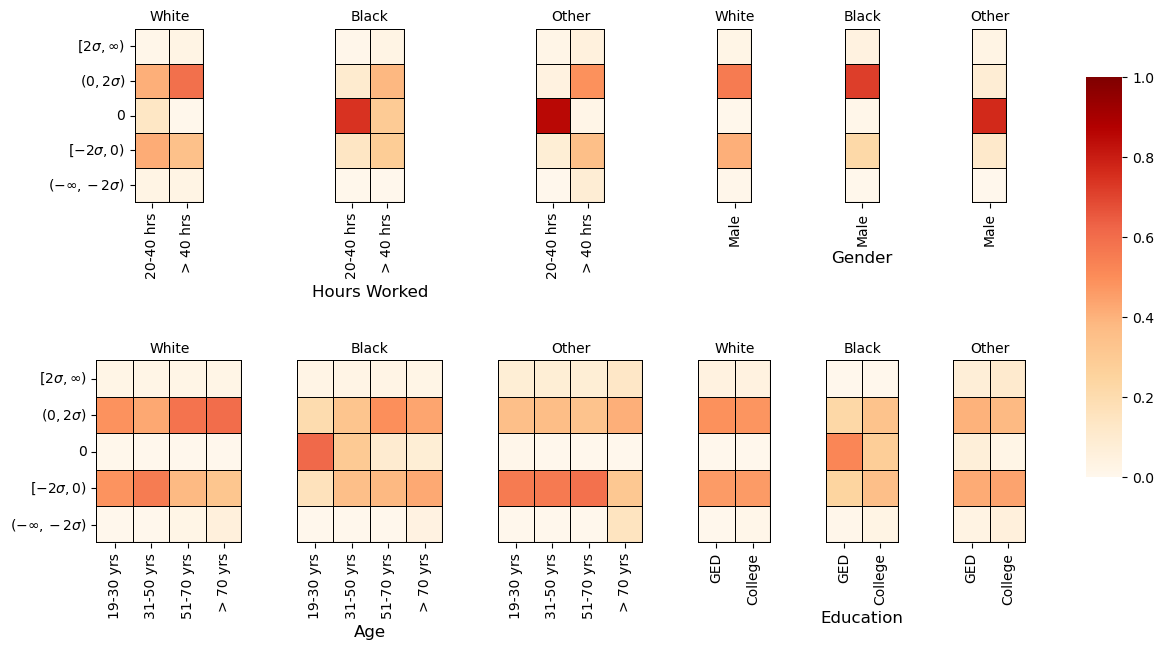

In [38]:
reorder = [0, 1, 2, 3]

cov_labels = ["Hours Worked", "Gender", "Age", "Education"]

levels_labels = [
    ["20-40 hrs", "> 40 hrs"],
    ["Male"],
    ["19-30 yrs", "31-50 yrs", "51-70 yrs", "> 70 yrs"],
    ["GED", "College"]
]

covariate_idx = 2
plot_matrix = signed_matrices[covariate_idx]

race_title = ["White", "Black", "Other"]

num_cov_vals = R[covariate_idx] - 2

fig = plt.figure(figsize=(12, 8)) #layout=None, facecolor='lightblue')
gs = fig.add_gridspec(nrows=1*2, ncols=3*2, #, left=0.05, right=0.75,
                      # hspace=0.3,
                      wspace=0.5,
                      width_ratios=[1, 1, 1, 0.5, 0.5, 0.5],
                      height_ratios=[0.45, 1]
                     )

cbar_ax = fig.add_axes([.95, .32, .03, .5])

if num_bins == 3:
    bin_labels = ["+", "0", "-"]
else:
    interval_length = 4 // (num_bins - 3)
    num_signed_levels = (2 // interval_length) - 1
    bin_labels = [r"$[2\sigma, \infty)$"]
    for i in range(num_signed_levels):
        label_i_str = rf"$[{2 - (i + 1) * interval_length}\sigma, {2 - i * interval_length}\sigma)$"
        bin_labels.append(label_i_str)
    bin_labels += [rf"$(0, {interval_length}\sigma)$", "0", rf"$[-{interval_length}\sigma, 0)$"]
    for i in range(num_signed_levels):
        label_i_str = rf"$[{-(2 + i) * interval_length}\sigma, {-(1 + i) * interval_length}\sigma)$"
        bin_labels.append(label_i_str)
    bin_labels.append(r"$(-\infty, -2\sigma)$")
        


for covariate_idx in range(4):

    i = covariate_idx // 2
    covariate_idx = reorder[covariate_idx]
    
    plot_matrix = signed_matrices[covariate_idx]
    num_cov_vals = R[covariate_idx] - 2
    
    for idx in range(3):
        # i = 0
        j = idx + (covariate_idx % 2) *3
    
        # print(plot_matrix[i][j])
    
        ax_ij = fig.add_subplot(gs[i, j])
        res = sns.heatmap(
            plot_matrix[idx].T,
            cmap="OrRd",
            linewidths=0.5,
            linecolor="black",
            square=True,
            vmin=0,
            vmax=1,
            ax=ax_ij,
            cbar_ax=cbar_ax
        )
        res.axhline(y=len(bins), color='black', linewidth=1.5)
        res.axvline(x=len(all_covariate_counts[covariate_idx][idx]), color='black', linewidth=1.5)
        ax_ij.set_title(race_title[idx], fontsize=10, rotation=0)
        ax_ij.set_yticks([])
        ax_ij.set_xticks(np.arange(0, num_cov_vals)+0.5, levels_labels[covariate_idx], rotation=90)
        if j == 0:
            ax_ij.set_yticks(np.arange(0, num_bins) + 0.5, bin_labels, rotation=0)
        # break

        if idx == 1:
            ax_ij.set_xlabel(cov_labels[covariate_idx], fontsize=12)
    # fig.supxlabel(cov_labels[covariate_idx])

fname = f"../Figures/nhanes/diff_covariate_effects_{num_bins}_bins.png"
    
plt.savefig(fname, dpi=300, bbox_inches="tight")

plt.show()

## Graphics for Explaining Heatmaps in Presentation

Hours Worked


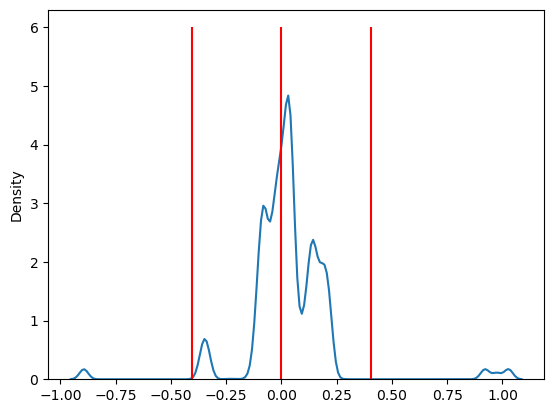

In [103]:
# Profile to consider is White 20-40 Hours

graphic_cov_idx, graphic_race_idx, group_idx = 1, 0, 0

print(cov_labels[0])
plot_effects = all_covariate_counts[graphic_cov_idx][graphic_race_idx][group_idx]

graphic_std = stds[graphic_cov_idx, graphic_race_idx]

sns.kdeplot(data=all_covariate_counts[graphic_cov_idx][graphic_race_idx][group_idx])
plt.vlines([-2 * graphic_std, 0 * graphic_std, 2 * graphic_std], ymin = 0, ymax=6, colors='r')
plt.show()

In [102]:
print(np.sum([1 if plot_effects[i] >= 0 and plot_effects[i] < 2 * graphic_std else 0 for i in range(len(plot_effects))]))

61458


In [91]:
len(df[(df['Race'] == 1) & (df['HoursWorked'] == 2)])

473